# Linear Optimizer of the fitpass classes

@roman_avj

21 08 2023

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

import pulp as plp

# Part 0: Read & Wrangle Data


In [5]:
# read raw data
df_fitpass_r = pd.read_parquet('../data/scrapped_fitpass_cdmx.parquet')

# look at the data
df_fitpass_r.head()

,gym_id,gym_name,pro_status,virtual_status,class_minutes,notes,latitude,longitude,address,barre,...,gym,hiit,mma,pilates,pool,running,sports,virtual_class,wellness,yoga
0,3913,21159 Fit Movement,0,0,45,Centro de entrenamiento Funcional en HIIT. Som...,19.409432,-99.162129,"Av. Monterrey 271, esquina calle aguascalientes",0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4356,321 Move!,0,0,None,Movimiento y espacio virtual y presencial de F...,19.359657,-99.202687,"Pasaje Las Águilas, Calzada de las Águilas 321...",1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3529,360Cycle Virtual,0,1,None,En 360CYCLE creemos que para obtener resultado...,21.118018,-101.656584,Blvd. Adolfo López Mateos,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5576,3 Are Legend,0,0,None,Entrenamiento Funcional y box.,19.539159,-99.182145,Jesus Reyes Heroles 112,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3735,40º Grados Bikram Yoga,0,0,None,Estudio de Bikram Yoga y más en Zona Esmeralda,19.552389,-99.270923,Av. Adolfo Ruiz Cortines 247,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 0.1: wrangle data 

### 0.1.1 generate fictional ranking data




min: 1.388739114573078, max: 4.97549881470397


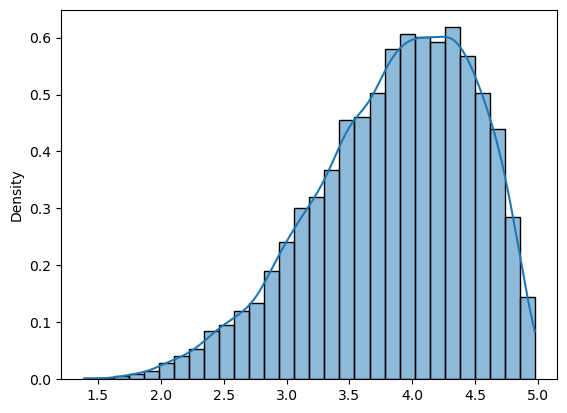

In [13]:
# fix random generator
rng = np.random.RandomState(8)

# generate 6*beta(5, 2) - 1 (rankings)
rnd_beta = 4*rng.beta(5, 2, size=10000) + 1

# plot beta distribution
sns.histplot(rnd_beta, stat='density', bins=30, kde=True)

# get range
print(f"min: {rnd_beta.min()}, max: {rnd_beta.max()}")

In [14]:
# generate fake rankings
df_fitpass_r["ranking"] = rng.beta(5, 2, size=df_fitpass_r.shape[0])

### 0.1.2: from EPSG:4326 to EPSG:6372


In [29]:
# change lon and lat dtypes from str to float
df_fitpass_r['longitude'] = df_fitpass_r['longitude'].astype(float)
df_fitpass_r['latitude'] = df_fitpass_r['latitude'].astype(float)

# pass the df to geopandas using the 'longitude' and 'latitude' columns to create a GeoDataFrame
gdf_fitpass_r = gpd.GeoDataFrame(df_fitpass_r, geometry=gpd.points_from_xy(df_fitpass_r.longitude, df_fitpass_r.latitude), crs="EPSG:4326")
gdf_fitpass_r = gdf_fitpass_r.to_crs("EPSG:6372")

# print
gdf_fitpass_r.geometry.head()


ProjError: x, y, z, and time must be same size

something wierd is happening with the coords

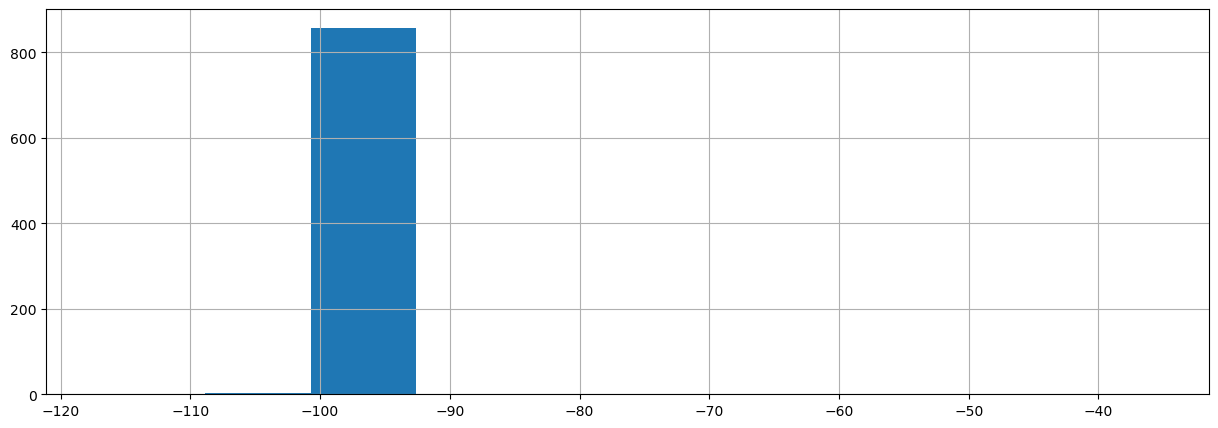

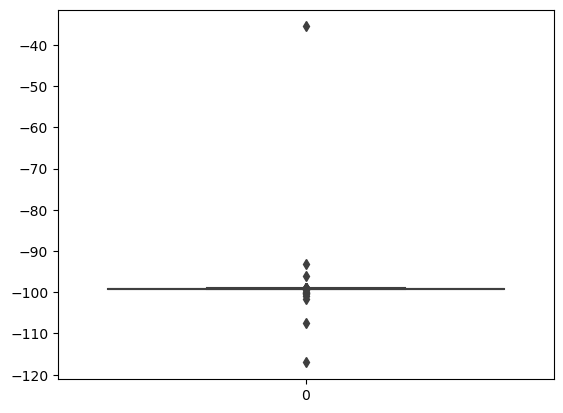

In [38]:
df_fitpass_r.longitude.describe()
df_fitpass_r.longitude.hist(bins=10, figsize=(15, 5))
plt.show()
sns.boxplot(df_fitpass_r.longitude)
plt.show()

In [41]:
df_fitpass_r.latitude.describe()



count    863.000000
mean      19.505291
std        1.701821
min       16.349820
25%       19.366204
50%       19.410814
75%       19.435136
max       66.358464
Name: latitude, dtype: float64

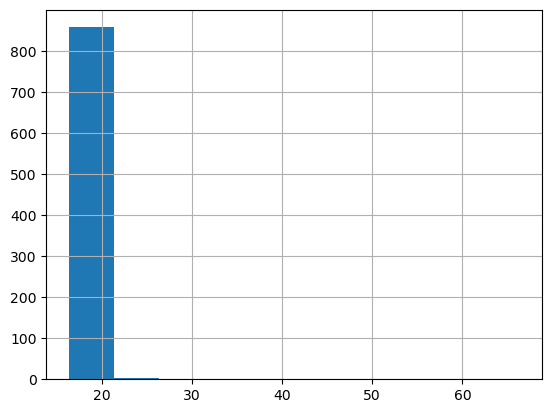

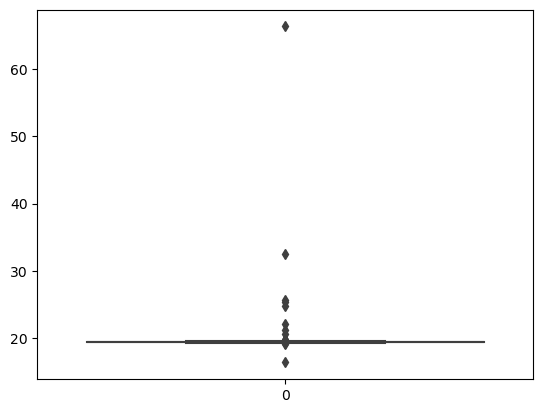

In [43]:
df_fitpass_r.latitude.hist(bins=10)
plt.show()
sns.boxplot(df_fitpass_r.latitude)
plt.show()

In [45]:
df_fitpass_r.latitude.describe()



count    863.000000
mean      19.505291
std        1.701821
min       16.349820
25%       19.366204
50%       19.410814
75%       19.435136
max       66.358464
Name: latitude, dtype: float64

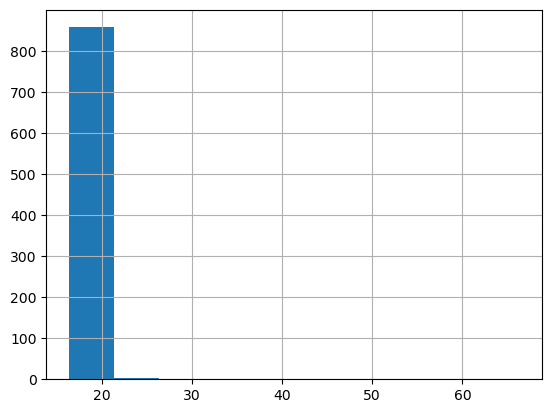

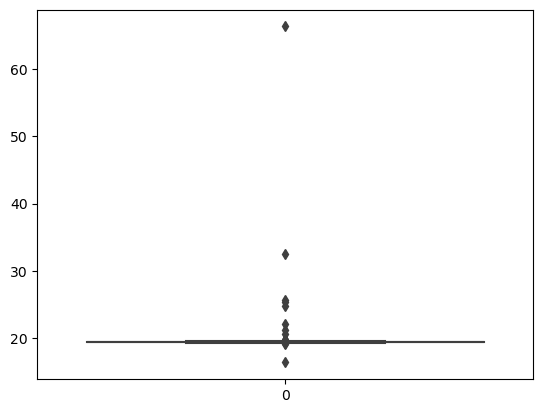

In [44]:

df_fitpass_r.latitude.hist(bins=10)
plt.show()
sns.boxplot(df_fitpass_r.latitude)
plt.show()

In [48]:
# plot points using folium
# initial possition of the map
m = folium.Map(location=[19.452519, -99.162381], tiles='cartodbpositron', zoom_start=12)

# add points to the map
for i, row in gdf_fitpass_r.iterrows():
    folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            tooltip=row['gym_name'],
            icon=folium.Icon(
                color="red",
                icon_color="black",
                weight=1,
                fill_opacity="black"
            )
        ).add_to(m)

# plot
m


what is happening is that i scraped info also from other states, therefore i need to filter the data to only include the state of interest

In [ ]:
# WIP

### 0.2: User payload


In [ ]:
user_info = {
    # user info
    "name": "roman",
    # location
    "latitude": -99.189679019841,
    "longitude": 19.356426878195325, 
    # constraints
    "fitpass_plan": "pro",
    "max_allowed_classes_per_class": 4,
    "num_classes_per_month": 20,
}

## 0.3: Fixed data

In [15]:
N_CLASSES = df_fitpass_r['gym_id'].nunique()
N_ACTIVITIES = 16 


In [17]:
df_fitpass_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gym_id          863 non-null    object 
 1   gym_name        863 non-null    object 
 2   pro_status      863 non-null    int64  
 3   virtual_status  863 non-null    int64  
 4   class_minutes   60 non-null     object 
 5   notes           863 non-null    object 
 6   latitude        863 non-null    object 
 7   longitude       863 non-null    object 
 8   address         863 non-null    object 
 9   barre           859 non-null    float64
 10  box             859 non-null    float64
 11  crossfit        859 non-null    float64
 12  cycling         859 non-null    float64
 13  dance           859 non-null    float64
 14  ems             859 non-null    float64
 15  functional      859 non-null    float64
 16  gym             859 non-null    float64
 17  hiit            859 non-null    flo